In [10]:
import matplotlib.pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import numpy as np
%matplotlib inline

In [235]:
import warnings
warnings.filterwarnings('ignore')

__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write function in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$

Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

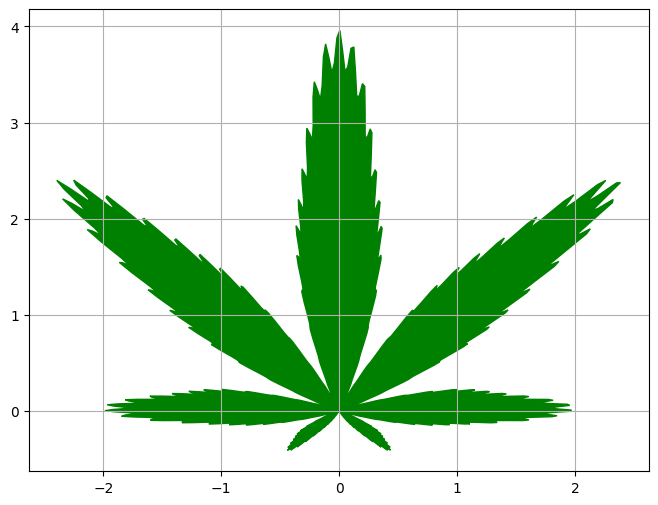

In [50]:
def compute_rho_carefully(th):
    first_term = 1 + 0.9 * torch.cos(8 * th)
    second_term = 1 + 0.1 * torch.cos(24 * th)
    third_term = 0.9 + 0.05 * torch.cos(200 * th)
    fourth_term = 1 + torch.sin(th)
    return first_term * second_term * third_term * fourth_term


theta = torch.linspace(-np.pi, np.pi, steps=1000)
rho = compute_rho_carefully(theta)
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)
plt.figure(figsize=[8, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

In [51]:
import json
z = np.concatenate([x, y])

with open('answer_1.json', 'w') as f:
    json.dump(z.tolist(), f)

### Task II: The Game of Life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](https://web.stanford.edu/class/sts129/Alife/html/Life.htm) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_NumPy code inspired by: https://github.com/rougier/numpy-100_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](https://stackoverflow.com/questions/16121269/2d-convolution-in-python-similar-to-matlabs-conv2), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [75]:
from scipy.signal import correlate2d

def np_update(Z):
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)
    Z[:] = birth | survive
    return Z

import torch
from torch.nn.functional import conv2d

def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    filters = torch.Tensor([[[[1, 1, 1],
                              [1, 0, 1],
                              [1, 1, 1]]]])
    if len(Z.shape) == 2:
        Z = Z[None, None, :, :]
    N = conv2d(Z, filters, padding=1)
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)
    Z[:] = birth | survive
    return Z

In [76]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)
# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

DA
Well done!


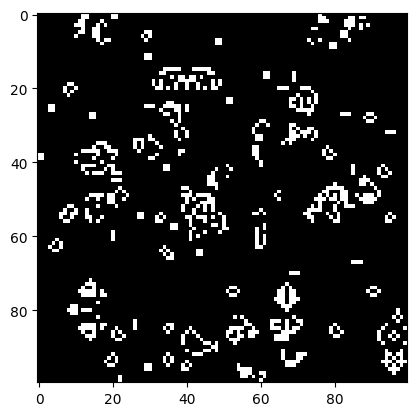

In [87]:
%matplotlib inline
import time
from IPython.display import clear_output
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(10):
    clear_output(True)
    Z = torch_update(Z)
    # re-draw image
    ax.clear()
    ax.imshow(Z[0, 0, :, :].numpy(), cmap='gray')
    fig.canvas.draw()

C:\Users\maxon\AppData\Local\Temp\ipykernel_5796\2641247576.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


DA


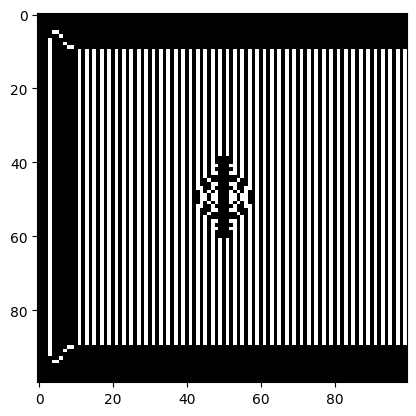

In [89]:
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(10):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z[0, 0, :, :].numpy(), cmap='gray')
    fig.canvas.draw()

### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>

Your third trial is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve yet another digit recognition problem, but at a greater scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](https://keras.io/api/losses/probabilistic_losses/)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.

__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [93]:
import torch
import numpy as np

def set_seed(random_seed: int = 42):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [ ]:
from torch.utils.data import Dataset, DataLoader

BATCH_SIZE = 512


'''
Your dataset item contains image and label (order matters — see train loop!)
'''
class NotMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

train_not_mnist_dataset = NotMNISTDataset(images=X_train, labels=y_train)
train_not_mnist_dataloader = DataLoader(
    train_not_mnist_dataset,
    batch_size=BATCH_SIZE,
)

test_not_mnist_dataset = NotMNISTDataset(images=X_test, labels=y_test)
test_not_mnist_dataloader = DataLoader(
    test_not_mnist_dataset,
    batch_size=BATCH_SIZE,
)


In [94]:
import torch
import torch.nn as nn


'''
hidden_dim=100 just works
'''
class SimpleModel(nn.Module):
    def __init__(self, hidden_dim: int = 100):
        super().__init__()
        model = nn.Sequential(
            nn.Linear(28**2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10),
            nn.Softmax()
        )

    def forward(self, images):
        output = self.model(images)
        return output

In [ ]:
import torch.nn.functional as F
import tqdm

set_seed()

def calc_batch_avg_accuracy(predicts, labels, batch_size):
    return (predicts.argmax(dim=1) == labels).sum() / BATCH_SIZE


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleModel()
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #0.0003

accs = []
train_accs = []
train_losses = []
n_epochs = 100

def calc_loss(model, images, labels):
    predicts = model(images)
    loss_value = F.nll_loss(predicts, labels)

    return loss_value

for epoch in tqdm.tqdm(range(n_epochs)):
    avg_loss = 0

    for batch in train_not_mnist_dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        loss_value = calc_loss(model, images, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        avg_loss += loss_value.item()

    train_losses.append(avg_loss)

    avg_acc = 0
        
    for batch in test_not_mnist_dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        predicts = model(images)

        accuracy = calc_batch_avg_accuracy(predicts, labels, batch_size=BATCH_SIZE)
        avg_acc += accuracy
        
    avg_acc /= len(test_not_mnist_dataloader)
    accs.append(avg_acc)

## Task IV. The Boston Housing Dataset

In [16]:
data = pd.read_csv("HousingData.csv")
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [23]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


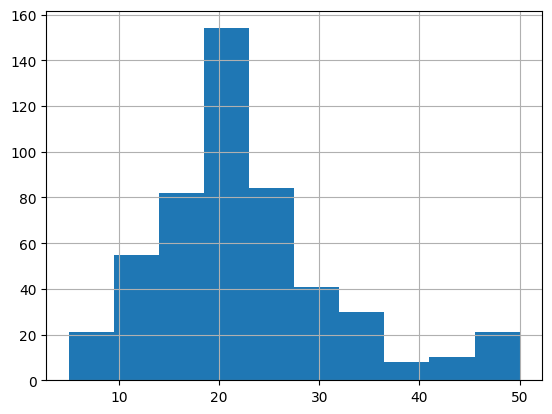

In [28]:
target = data["MEDV"]
plt.hist(target)
plt.grid(True)

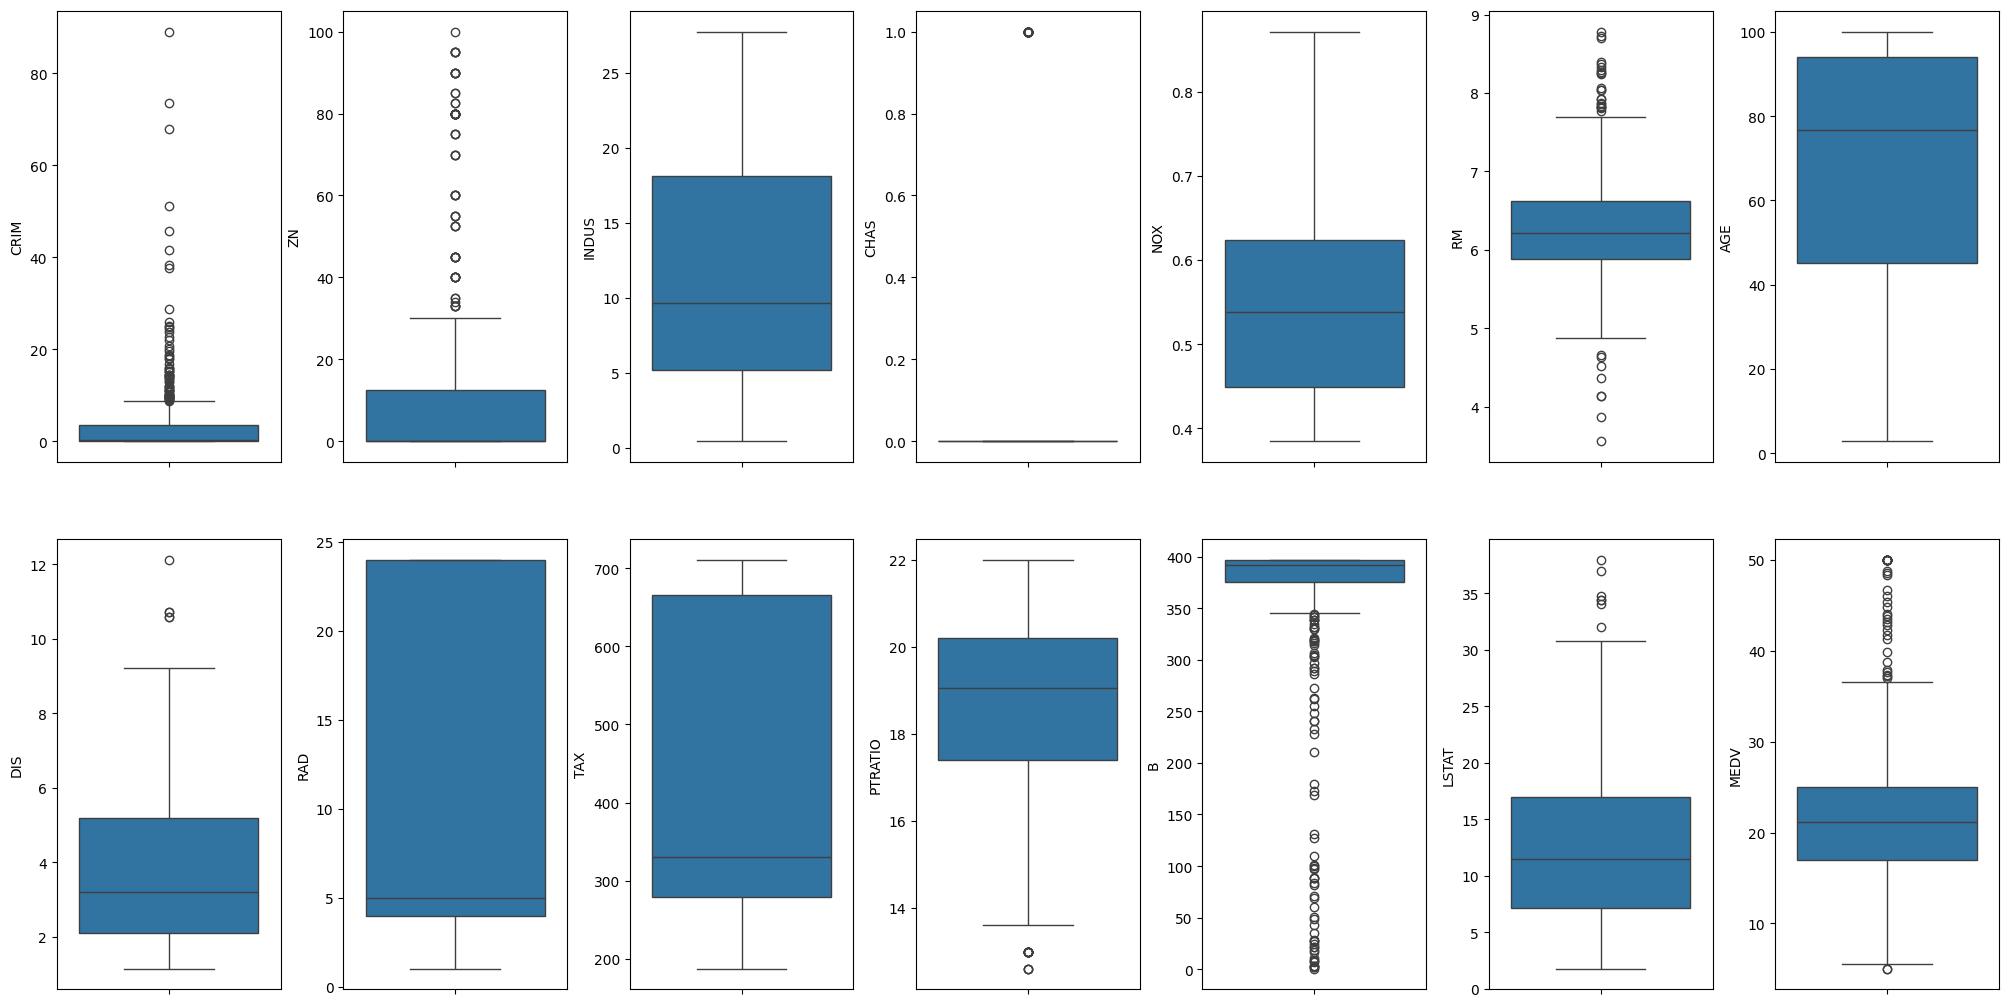

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.boxplot(y=k, data=data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

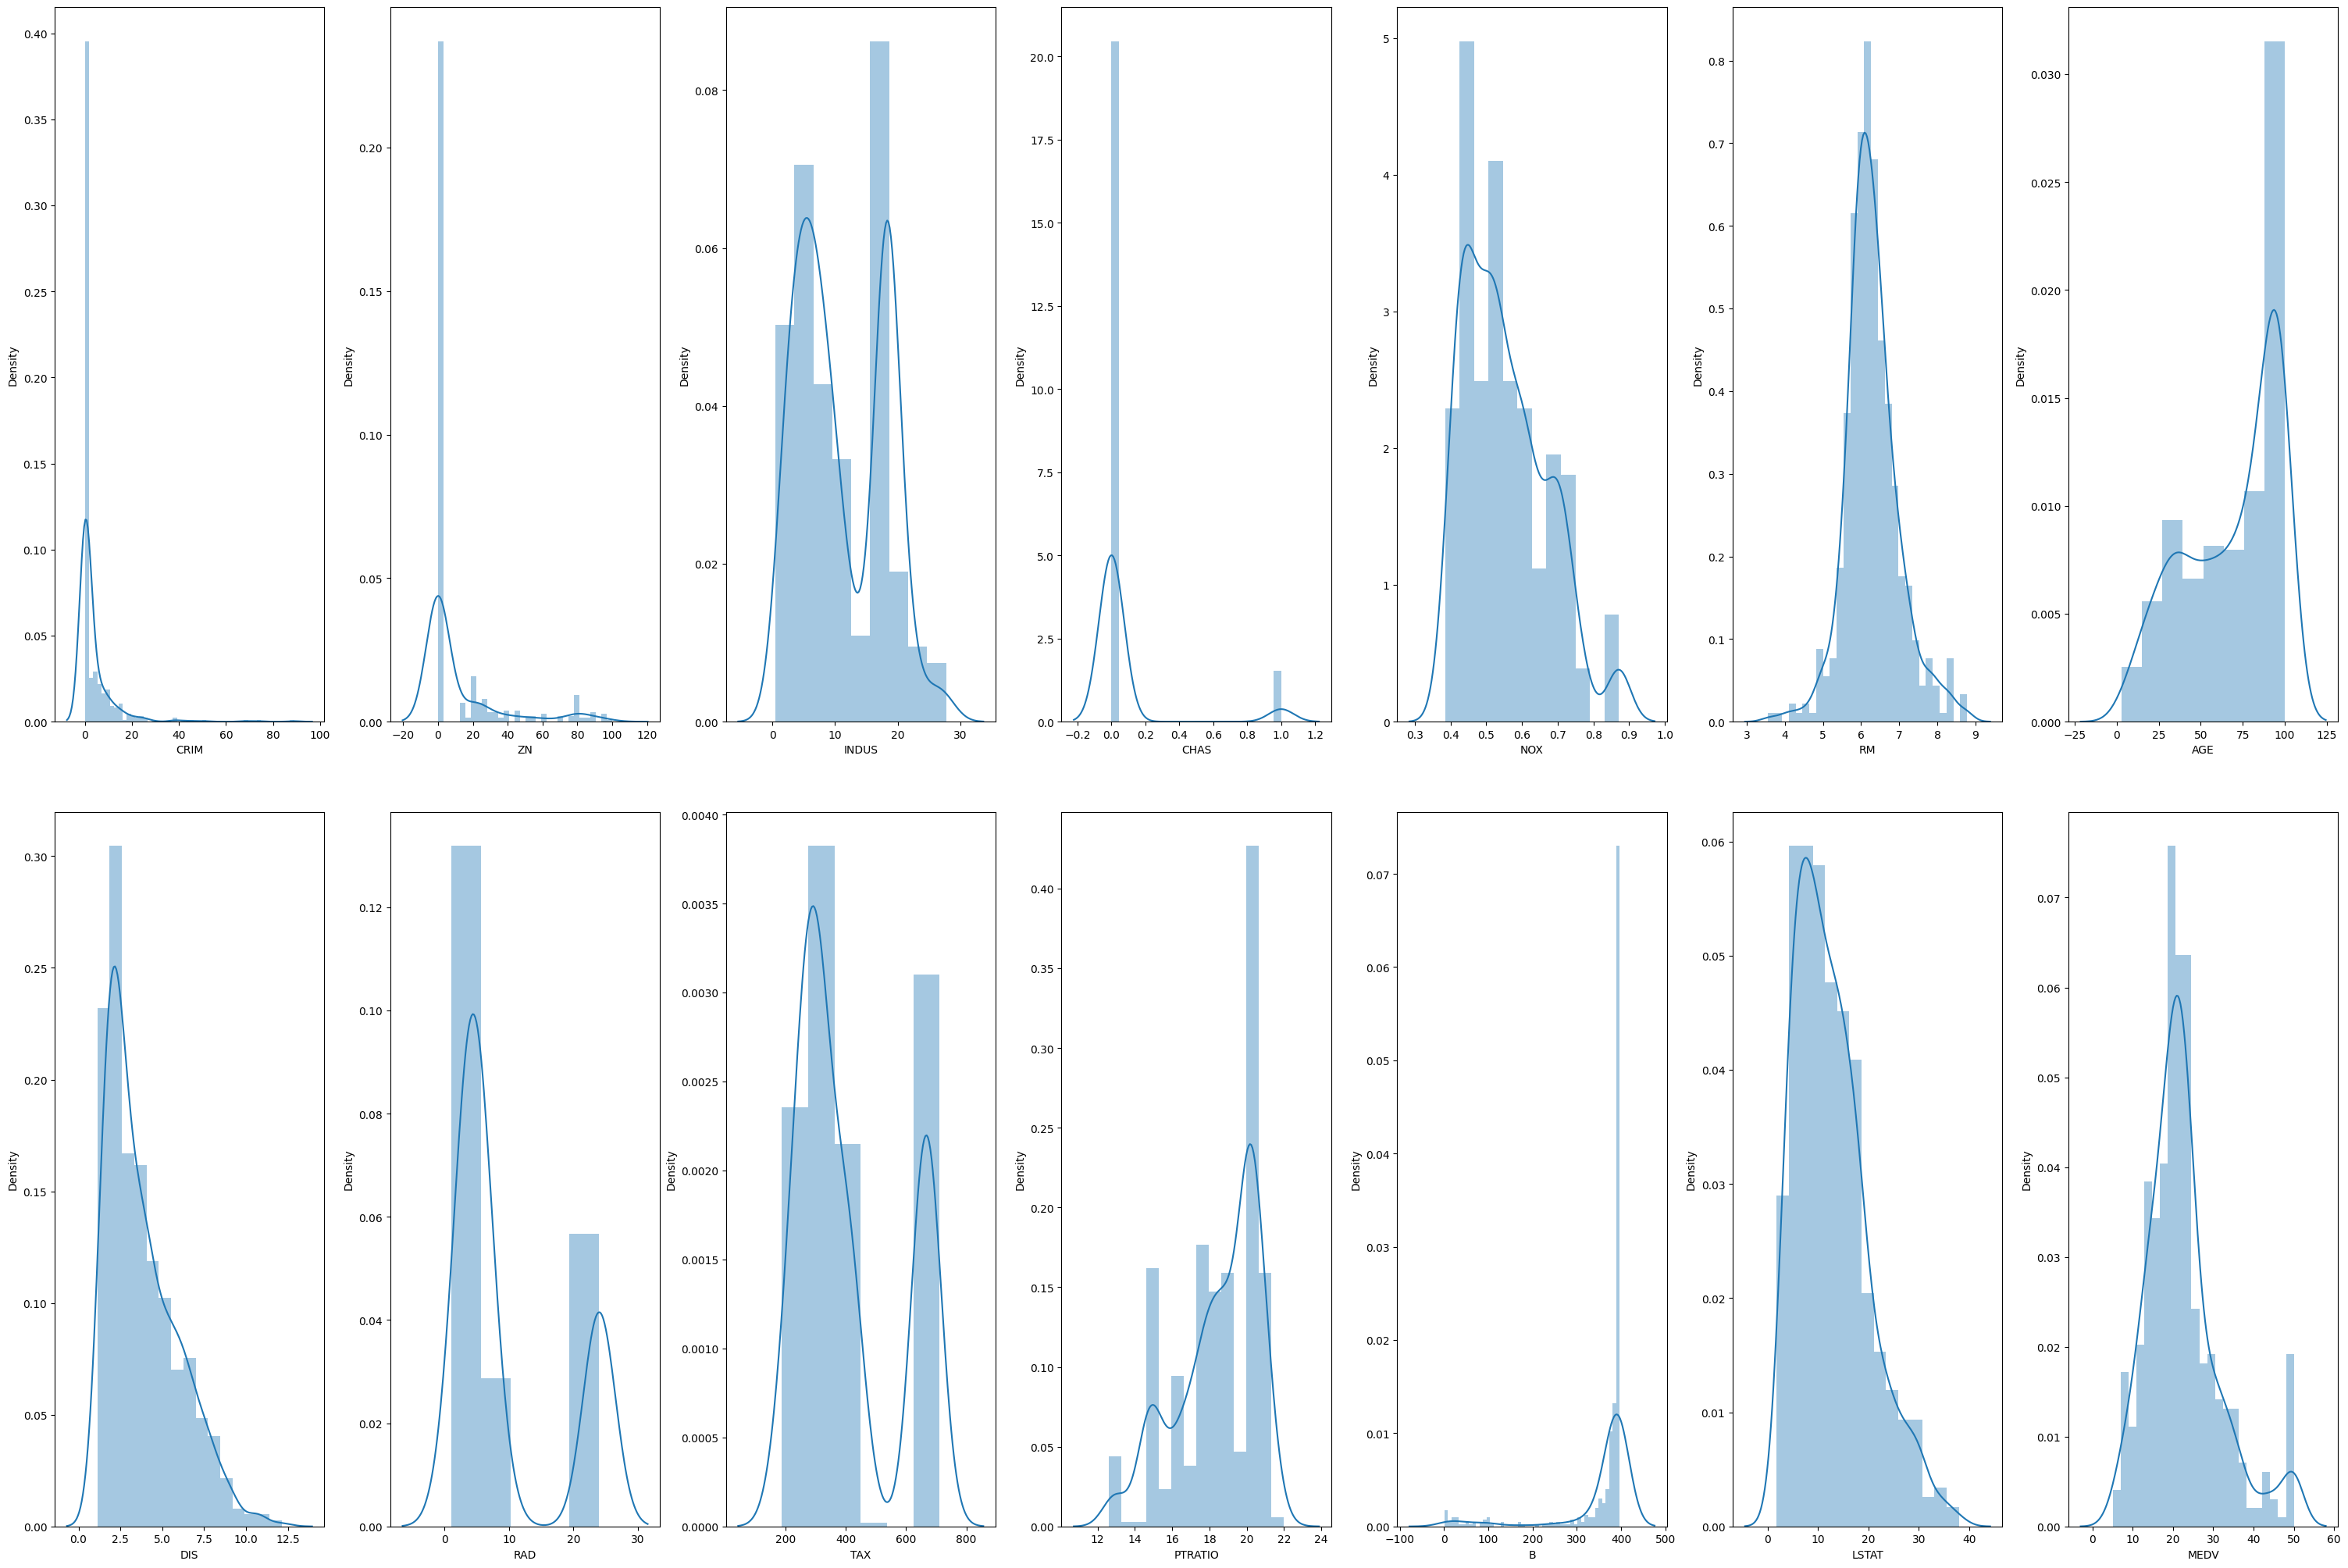

In [236]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(30, 20))
index = 0
axs = axs.flatten()
for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [42]:
x = torch.tensor(data.iloc[:, -1] / data.iloc[:, -1].max(), dtype=torch.float32)
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
y = torch.tensor(target, dtype=torch.float32)

assert w.grad is None
assert b.grad is None

In [32]:
w, b

(tensor([0.0969], requires_grad=True), tensor([0.8676], requires_grad=True))

In [36]:
x.shape, y.shape

(torch.Size([506]), torch.Size([506]))

Линейная регрессия 

In [43]:
y_pred = w * x + b
loss = torch.mean((y_pred - y) ** 2)
loss.backward() # compute gradients

In [44]:
assert w.grad is not None
assert b.grad is not None
print("dL/dw = ", w.grad)
print("dL/db = ", b.grad)

dL/dw =  tensor([-22.7628])
dL/db =  tensor([-43.0356])


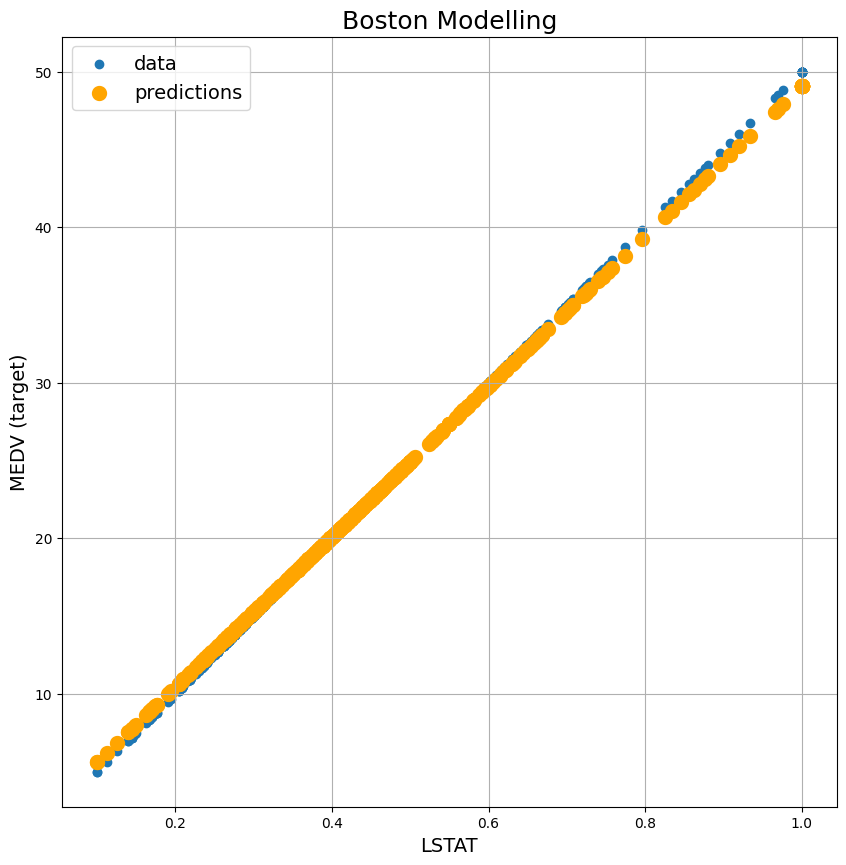

loss =  0.09894654
Done!


In [47]:
from IPython.display import clear_output


ALPHA = 0.05
max_iterations = 3000
tol = .1

for i in range(max_iterations):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()
    w.data -= ALPHA * w.grad
    b.data -= ALPHA * b.grad

    w.grad.data.zero_()
    b.grad.data.zero_()

    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(10,10))
        plt.scatter(x.data.numpy(), y.data.numpy(), label='data')
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange',
                    linewidth=5, label='predictions')
        plt.xlabel("LSTAT", fontsize=14)
        plt.ylabel("MEDV (target)", fontsize=14)
        plt.title("Boston Modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.grid(True)
        plt.show()
        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < tol:
            print("Done!")
            break

### 4.2 My first neural network

In [95]:
class RandomDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :], dtype=torch.float), "target": y[idx]}

In [96]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)
x[:10, :5]

array([[0.72548885, 0.49896467, 0.87591793, 0.54362739, 0.23354375],
       [0.44279678, 0.76079342, 0.47223498, 0.1359626 , 0.3585237 ],
       [0.24596728, 0.32631187, 0.91818569, 0.45963956, 0.28745956],
       [0.20426126, 0.37374584, 0.61072594, 0.57871493, 0.33867962],
       [0.44723171, 0.24038381, 0.78202076, 0.11028686, 0.1231854 ],
       [0.75292767, 0.64296414, 0.26687602, 0.18753703, 0.37058181],
       [0.18066555, 0.6159374 , 0.11089874, 0.92177751, 0.17178685],
       [0.81535417, 0.06901603, 0.95161861, 0.85856891, 0.65542944],
       [0.60534627, 0.77276361, 0.90919147, 0.18057928, 0.30366186],
       [0.02943867, 0.47957428, 0.42026727, 0.29851805, 0.97579628]])

##### Dataset and Dataloader

In [98]:
dataset = RandomDataset(x, y)
dataset[1] # equal dataset.__getitem__(1)

{'sample': tensor([0.4428, 0.7608, 0.4722, 0.1360, 0.3585]),
 'target': 0.8621684703561959}

In [103]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
batch = next(iter(dataloader))
print("Batch:", batch)
print(f"\nBatch Sample: {batch["sample"]}")
print(f"\nBatch Target: {batch["target"]}")

Batch: {'sample': tensor([[0.7255, 0.4990, 0.8759, 0.5436, 0.2335],
        [0.4428, 0.7608, 0.4722, 0.1360, 0.3585],
        [0.2460, 0.3263, 0.9182, 0.4596, 0.2875],
        [0.2043, 0.3737, 0.6107, 0.5787, 0.3387]]), 'target': tensor([0.1438, 0.8622, 0.2071, 0.9300], dtype=torch.float64)}

Batch Sample: tensor([[0.7255, 0.4990, 0.8759, 0.5436, 0.2335],
        [0.4428, 0.7608, 0.4722, 0.1360, 0.3585],
        [0.2460, 0.3263, 0.9182, 0.4596, 0.2875],
        [0.2043, 0.3737, 0.6107, 0.5787, 0.3387]])

Batch Target: tensor([0.1438, 0.8622, 0.2071, 0.9300], dtype=torch.float64)


##### Creating nn

In [126]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
           nn.Linear(5, 10),
           nn.ReLU(),
           nn.Linear(10, 1)
        )

    def forward(self, X):
        return self.model(X)

In [128]:
simple_model = SimpleModel()
y_pred = simple_model(batch['sample'])
y_pred

tensor([[ 0.0679],
        [-0.0352],
        [ 0.0963],
        [ 0.0733]], grad_fn=<AddmmBackward0>)

## Task V. MNIST

In [129]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 11074945.60it/s]


Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14470874.90it/s]


Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 7443029.04it/s]


Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 4551010.22it/s]

Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



In [130]:
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
) 

In [132]:
mnist_val.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [133]:
train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=4,
    shuffle=True,
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=4,
    shuffle=True,
    num_workers=1
)

In [157]:
def plot_digit(data):
    i = np.random.randint(0, 9999)
    plt.imshow(data[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(data[i][1]))

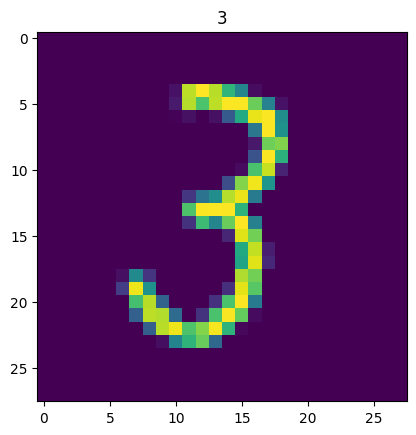

In [159]:
plot_digit(mnist_train)

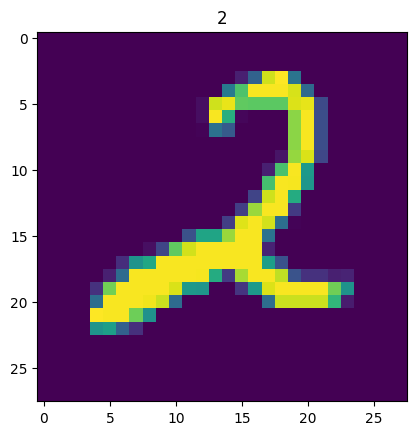

In [160]:
plot_digit(mnist_val)

In [224]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=0)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [225]:
[x for x in model.named_parameters()]

[('1.weight',
  Parameter containing:
  tensor([[ 0.0224, -0.0218,  0.0004,  ...,  0.0052,  0.0155, -0.0066],
          [ 0.0156, -0.0207,  0.0149,  ..., -0.0056, -0.0022,  0.0142],
          [ 0.0227, -0.0196,  0.0092,  ..., -0.0194,  0.0098, -0.0078],
          ...,
          [-0.0320, -0.0322,  0.0047,  ..., -0.0238,  0.0193, -0.0218],
          [ 0.0345,  0.0312, -0.0180,  ..., -0.0120,  0.0341, -0.0033],
          [-0.0302,  0.0164, -0.0175,  ...,  0.0029, -0.0300,  0.0231]],
         requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([-0.0076, -0.0132, -0.0331, -0.0030,  0.0148, -0.0141,  0.0335, -0.0089,
           0.0298, -0.0226, -0.0295,  0.0327, -0.0254, -0.0029,  0.0085,  0.0022,
           0.0212,  0.0297,  0.0333,  0.0035, -0.0082, -0.0002,  0.0322, -0.0268,
           0.0100,  0.0142,  0.0060, -0.0353, -0.0308,  0.0261,  0.0291, -0.0229,
           0.0118,  0.0093, -0.0215,  0.0284, -0.0303,  0.0331,  0.0174,  0.0099,
           0.0186,  0.0259, -0.0288, 

In [178]:
from tqdm import tqdm

In [182]:
for epoch in range(5):
    for x_train, y_train in train_dataloader:
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 2 == 0:
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        wandb.log("mean val loss": np.mean(val_loss),
                 "mean val accuracy": np.mean(val_accuracy))
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

Epoch: 0, loss: 0.09508095681667328, accuracy: 0.97105
Epoch: 2, loss: 0.05085921287536621, accuracy: 0.983
Epoch: 4, loss: 0.03545404225587845, accuracy: 0.98765


In [226]:
model.eval()
with torch.no_grad():
    outputs = model.forward(mnist_val.data.to(torch.float32))

In [230]:
# Prediction for the first sample
outputs[0].argmax()

tensor(7)